# Aircraft Trajectory Prediction Using LSTM

This project predicts short-term aircraft trajectories using real ADS-B
state vector data from the OpenSky Network. A complete pipeline is implemented,
including data acquisition, preprocessing, LSTM-based modeling, and trajectory
evaluation.


## 1. Data Acquisition (OpenSky ADS-B State Vectors)


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta


## 1. Data Acquisition (OpenSky ADS-B)


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
import pandas as pd

df = pd.read_csv("/content/drive/My Drive/states_2017-06-05-00.csv")

print("Dataset loaded successfully")
print("Number of rows:", len(df))
df.head()


Dataset loaded successfully
Number of rows: 1526689


,time,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,alert,spi,squawk,baroaltitude,geoaltitude,lastposupdate,lastcontact
0,1496620800,4bccb9,52.084916,11.445394,175.320557,305.321045,NaN,SXS2WY,False,False,False,1000.0,7459.98,7581.90,1.496621e+09,1.496621e+09
1,1496620800,502cb2,49.637375,2.871841,232.936358,305.199350,-0.32512,MON55BR,False,False,False,2770.0,10988.04,11033.76,1.496621e+09,1.496621e+09
2,1496620800,4bccaf,49.850464,12.522783,196.684570,288.764648,NaN,SXS7R,False,False,False,3215.0,11582.40,11772.90,1.496621e+09,1.496621e+09
3,1496620800,4008e1,50.780847,9.262612,214.205322,292.747192,NaN,TCX229,False,False,False,3462.0,10363.20,NaN,1.496621e+09,1.496621e+09
4,1496620800,4070e3,50.722992,3.823700,221.822622,297.634765,0.32512,EXS14D,False,False,False,7775.0,10972.80,11033.76,1.496621e+09,1.496621e+09


## 2. Data Understanding and Cleaning



In [36]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526689 entries, 0 to 1526688
Data columns (total 16 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   time           1526689 non-null  int64  
 1   icao24         1526689 non-null  object 
 2   lat            1075733 non-null  float64
 3   lon            1075733 non-null  float64
 4   velocity       1035889 non-null  float64
 5   heading        1035889 non-null  float64
 6   vertrate       1077336 non-null  float64
 7   callsign       925285 non-null   object 
 8   onground       1526689 non-null  bool   
 9   alert          1526689 non-null  bool   
 10  spi            1526689 non-null  bool   
 11  squawk         1275709 non-null  float64
 12  baroaltitude   1380631 non-null  float64
 13  geoaltitude    943247 non-null   float64
 14  lastposupdate  1075733 non-null  float64
 15  lastcontact    1526689 non-null  float64
dtypes: bool(3), float64(10), int64(1), object(2)
memory us

In [37]:
df.describe()


,time,lat,lon,velocity,heading,vertrate,squawk,baroaltitude,geoaltitude,lastposupdate,lastcontact
count,1.526689e+06,1.075733e+06,1.075733e+06,1.035889e+06,1.035889e+06,1.077336e+06,1.275709e+06,1.380631e+06,943247.000000,1.075733e+06,1.526689e+06
mean,1.496623e+09,3.196571e+01,-4.893514e+01,1.830698e+02,1.817076e+02,1.713002e-01,4.295310e+03,7.359487e+03,7752.478764,1.496622e+09,1.496623e+09
std,1.033893e+03,2.060763e+01,7.957214e+01,7.339144e+01,1.019075e+02,1.465976e+01,2.745468e+03,4.515939e+03,4267.105428,2.592819e+03,1.033002e+03
min,1.496621e+09,-3.938240e+01,-1.558108e+02,0.000000e+00,-0.000000e+00,-1.034415e+03,0.000000e+00,-3.657600e+02,-822.960000,1.496496e+09,1.496621e+09
25%,1.496622e+09,3.277226e+01,-9.960293e+01,1.336783e+02,8.881881e+01,-3.251200e-01,1.765000e+03,3.063240e+03,3489.960000,1.496622e+09,1.496622e+09
50%,1.496623e+09,3.754815e+01,-8.015234e+01,2.120670e+02,1.820700e+02,0.000000e+00,3.410000e+03,8.938260e+03,9745.980000,1.496622e+09,1.496623e+09
75%,1.496623e+09,4.137046e+01,-2.779855e+00,2.374687e+02,2.714539e+02,3.251200e-01,7.277000e+03,1.097280e+04,11277.600000,1.496623e+09,1.496623e+09
max,1.496624e+09,6.462886e+01,1.749207e+02,5.960894e+02,3.598801e+02,1.697355e+03,7.777000e+03,3.864864e+04,38465.760000,1.496624e+09,1.496624e+09


In [38]:
# Keep only airborne aircraft
df = df[df["onground"] == False]

# Drop rows with missing critical values
df = df.dropna(subset=["lat", "lon", "velocity", "heading", "baroaltitude"])

# Convert time to datetime
df["time"] = pd.to_datetime(df["time"], unit="s")

# Sort by aircraft and time
df = df.sort_values(["icao24", "time"])

df.head()


,time,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,alert,spi,squawk,baroaltitude,geoaltitude,lastposupdate,lastcontact
11818,2017-06-05 00:00:40,00f888,40.813092,-73.275625,230.907432,53.972627,-6.50240,NaN,False,False,False,NaN,6903.72,6896.10,1.496621e+09,1.496621e+09
19116,2017-06-05 00:00:50,00f888,40.834599,-73.245725,225.691455,51.850109,-6.82752,NaN,False,False,False,NaN,6781.80,6774.18,1.496621e+09,1.496621e+09
20465,2017-06-05 00:01:00,00f888,40.851791,-73.225281,222.137968,49.225998,-7.15264,NaN,False,False,False,NaN,6690.36,6682.74,1.496621e+09,1.496621e+09
26915,2017-06-05 00:01:10,00f888,40.851791,-73.225281,222.137968,49.225998,-7.15264,NaN,False,False,False,NaN,6690.36,6682.74,1.496621e+09,1.496621e+09
29181,2017-06-05 00:01:20,00f888,40.862000,-73.217285,219.812717,46.706985,-7.80288,NaN,False,False,False,NaN,6621.78,6614.16,1.496621e+09,1.496621e+09


## 3. Extract a Single Aircraft Trajectory


In [39]:
# Choose one aircraft (first ICAO24 code)
aircraft_id = df["icao24"].iloc[0]
df_aircraft = df[df["icao24"] == aircraft_id]

print("Selected aircraft:", aircraft_id)
print("Number of points:", len(df_aircraft))
df_aircraft.head()


Selected aircraft: 00f888
Number of points: 86


,time,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,alert,spi,squawk,baroaltitude,geoaltitude,lastposupdate,lastcontact
11818,2017-06-05 00:00:40,00f888,40.813092,-73.275625,230.907432,53.972627,-6.50240,NaN,False,False,False,NaN,6903.72,6896.10,1.496621e+09,1.496621e+09
19116,2017-06-05 00:00:50,00f888,40.834599,-73.245725,225.691455,51.850109,-6.82752,NaN,False,False,False,NaN,6781.80,6774.18,1.496621e+09,1.496621e+09
20465,2017-06-05 00:01:00,00f888,40.851791,-73.225281,222.137968,49.225998,-7.15264,NaN,False,False,False,NaN,6690.36,6682.74,1.496621e+09,1.496621e+09
26915,2017-06-05 00:01:10,00f888,40.851791,-73.225281,222.137968,49.225998,-7.15264,NaN,False,False,False,NaN,6690.36,6682.74,1.496621e+09,1.496621e+09
29181,2017-06-05 00:01:20,00f888,40.862000,-73.217285,219.812717,46.706985,-7.80288,NaN,False,False,False,NaN,6621.78,6614.16,1.496621e+09,1.496621e+09


In [40]:
df_aircraft["time"].diff().describe()


,time
count,85
mean,0 days 00:00:10
std,0 days 00:00:00
min,0 days 00:00:10
25%,0 days 00:00:10
50%,0 days 00:00:10
75%,0 days 00:00:10
max,0 days 00:00:10


## 4. Time-Series Preparation for LSTM


In [41]:
df_aircraft = df_aircraft.set_index("time")

features = [
    "lat",
    "lon",
    "velocity",
    "heading",
    "baroaltitude"
]

df_model = df_aircraft[features]
df_model.head()


,lat,lon,velocity,heading,baroaltitude
time,,,,,
2017-06-05 00:00:40,40.813092,-73.275625,230.907432,53.972627,6903.72
2017-06-05 00:00:50,40.834599,-73.245725,225.691455,51.850109,6781.80
2017-06-05 00:01:00,40.851791,-73.225281,222.137968,49.225998,6690.36
2017-06-05 00:01:10,40.851791,-73.225281,222.137968,49.225998,6690.36
2017-06-05 00:01:20,40.862000,-73.217285,219.812717,46.706985,6621.78


In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_values = scaler.fit_transform(df_model)

df_scaled = pd.DataFrame(
    scaled_values,
    index=df_model.index,
    columns=df_model.columns
)

df_scaled.head()


,lat,lon,velocity,heading,baroaltitude
time,,,,,
2017-06-05 00:00:40,-2.199037,-1.895513,2.830239,0.224949,2.511468
2017-06-05 00:00:50,-2.097922,-1.807982,2.406866,-0.011080,2.357130
2017-06-05 00:01:00,-2.017092,-1.748134,2.118434,-0.302888,2.241377
2017-06-05 00:01:10,-2.017092,-1.748134,2.118434,-0.302888,2.241377
2017-06-05 00:01:20,-1.969099,-1.724728,1.929696,-0.583009,2.154562


## 5. LSTM Sequence Generation


In [43]:
import numpy as np

def create_sequences(data, input_steps=10, output_steps=1):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps):
        X.append(data[i:i + input_steps])
        y.append(data[i + input_steps:i + input_steps + output_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled.values)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (75, 10, 5)
y shape: (75, 1, 5)


## 6. LSTM Model Architecture and Training


In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(y.shape[2])
])

model.compile(optimizer="adam", loss="mse")
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,501 (119.14 KB)

 Trainable params: 30,501 (119.14 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = model.fit(
    X,
    y.reshape(y.shape[0], y.shape[2]),
    epochs=30,
    batch_size=8,
    validation_split=0.2,
    verbose=1
)


Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - loss: 0.6936 - val_loss: 0.5826
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3761 - val_loss: 0.2720
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1987 - val_loss: 0.0660
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1077 - val_loss: 0.0031
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0768 - val_loss: 0.0060
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0756 - val_loss: 0.0033
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0470 - val_loss: 0.0094
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0475 - val_loss: 0.0048
Epoch 9/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0394 - val_loss: 0.0079
Epoch 10/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0322 - val_loss: 6.0849e-04
Epoch 11/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0351 - val_loss: 0.0037
Epoch 12/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0220 - val_loss: 0.0

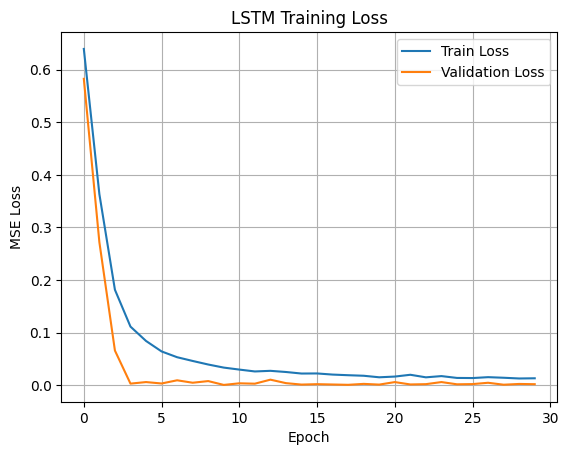

In [45]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("LSTM Training Loss")
plt.legend()
plt.grid()
plt.show()


## 7. Prediction and Trajectory Evaluation


In [46]:
y_pred = model.predict(X)

y_pred_real = scaler.inverse_transform(y_pred)
y_true_real = scaler.inverse_transform(
    y.reshape(y.shape[0], y.shape[2])
)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


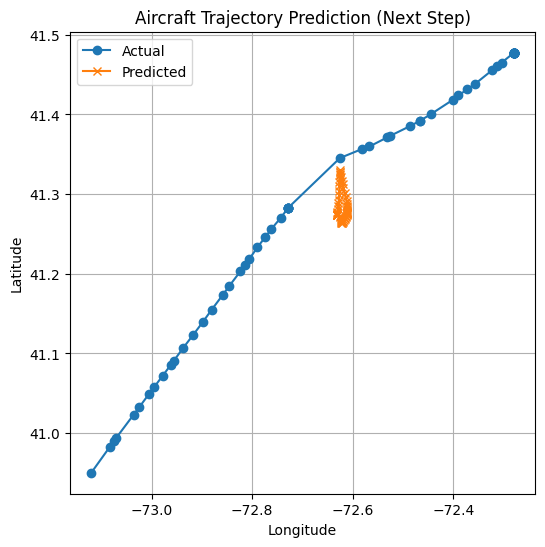

In [47]:
plt.figure(figsize=(6, 6))
plt.plot(y_true_real[:, 1], y_true_real[:, 0], label="Actual", marker="o")
plt.plot(y_pred_real[:, 1], y_pred_real[:, 0], label="Predicted", marker="x")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Aircraft Trajectory Prediction (Next Step)")
plt.legend()
plt.grid()
plt.show()


## Conclusion

This project demonstrates a complete end-to-end pipeline for aircraft
trajectory prediction using LSTM neural networks and real ADS-B data
from the OpenSky Network.

Future improvements may include:
- Multi-step trajectory prediction

- Training on multiple aircraft
- Incorporating weather or wind data
